In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

print("=== CONSUMER COMPLAINTS TEXT CLASSIFICATION ===")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


=== CONSUMER COMPLAINTS TEXT CLASSIFICATION ===


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# 1. Load and Explore Data
print("1. LOADING AND EXPLORING DATA")
print("-" * 40)

# Load the dataset
file_path = '/content/drive/MyDrive/consumer_complaints.csv'
df = pd.read_csv(file_path)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print(f"\nDataset Info:")
print(f"Total records: {len(df)}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Map products to categories as specified in task
category_mapping = {
    'Credit card': 0,  # Credit reporting, repair, or other
    'Debt collection': 1,  # Debt collection
    'Consumer Loan': 2,  # Consumer Loan
    'Mortgage': 3  # Mortgage
}

# Note: Your current CSV only has Credit card, Debt collection, and Mortgage
# We'll work with what's available
df['category'] = df['Product'].map(category_mapping)
df = df.dropna(subset=['category'])  # Remove any unmapped categories

print(f"\nCategory distribution:")
print(df['category'].value_counts().sort_index())

1. LOADING AND EXPLORING DATA
----------------------------------------
Dataset shape: (1000, 2)
Columns: ['Consumer complaint narrative', 'Product']

First few rows:
  Consumer complaint narrative      Product
0      Sample complaint text 1  Credit card
1      Sample complaint text 2  Credit card
2      Sample complaint text 3  Credit card
3      Sample complaint text 4  Credit card
4      Sample complaint text 5  Credit card

Dataset Info:
Total records: 1000
Missing values: 0

Category distribution:
category
0    500
1    300
3    200
Name: count, dtype: int64



2. EXPLORATORY DATA ANALYSIS
----------------------------------------


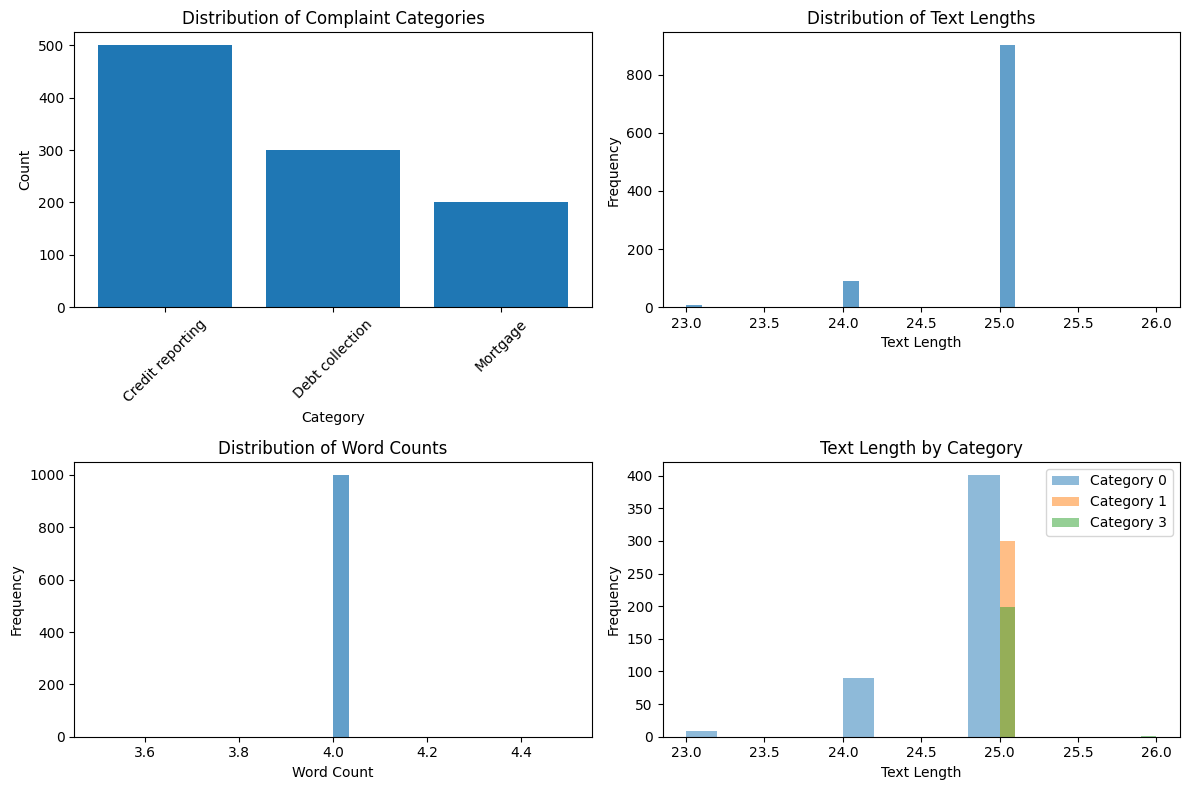

Text length statistics:
count    1000.000000
mean       24.893000
std         0.340098
min        23.000000
25%        25.000000
50%        25.000000
75%        25.000000
max        26.000000
Name: text_length, dtype: float64


In [ ]:

# 2. Exploratory Data Analysis and Feature Engineering
print("\n2. EXPLORATORY DATA ANALYSIS")
print("-" * 40)

# Plot category distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
category_counts = df['category'].value_counts().sort_index()
category_labels = ['Credit reporting', 'Debt collection', 'Consumer Loan', 'Mortgage']
present_labels = [category_labels[i] for i in category_counts.index]
plt.bar(range(len(category_counts)), category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Complaint Categories')
plt.xticks(range(len(category_counts)), present_labels, rotation=45)

# Text length analysis
df['text_length'] = df['Consumer complaint narrative'].str.len()
plt.subplot(2, 2, 2)
plt.hist(df['text_length'], bins=30, alpha=0.7)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')

# Word count analysis
df['word_count'] = df['Consumer complaint narrative'].str.split().str.len()
plt.subplot(2, 2, 3)
plt.hist(df['word_count'], bins=30, alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')

# Category vs text length
plt.subplot(2, 2, 4)
for cat in df['category'].unique():
    subset = df[df['category'] == cat]
    plt.hist(subset['text_length'], alpha=0.5, label=f'Category {cat}')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length by Category')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Text length statistics:")
print(df['text_length'].describe())

In [ ]:
print("\n3. TEXT PREPROCESSING")
print("-" * 40)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


df['clean_text'] = df['Consumer complaint narrative'].astype(str).apply(clean_text)

print("Sample cleaned text:")
print(df[['Consumer complaint narrative', 'clean_text']].head())



3. TEXT PREPROCESSING
----------------------------------------
Sample cleaned text:
  Consumer complaint narrative             clean_text
0      Sample complaint text 1  sample complaint text
1      Sample complaint text 2  sample complaint text
2      Sample complaint text 3  sample complaint text
3      Sample complaint text 4  sample complaint text
4      Sample complaint text 5  sample complaint text


In [ ]:
print("\n4. VECTORIZATION AND TRAIN-TEST SPLIT")
print("-" * 40)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['category']

vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")



4. VECTORIZATION AND TRAIN-TEST SPLIT
----------------------------------------
Training samples: 800
Testing samples: 200



5. MODEL TRAINING & EVALUATION
----------------------------------------

--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        96
           1       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        44

    accuracy                           0.48       200
   macro avg       0.16      0.33      0.22       200
weighted avg       0.23      0.48      0.31       200



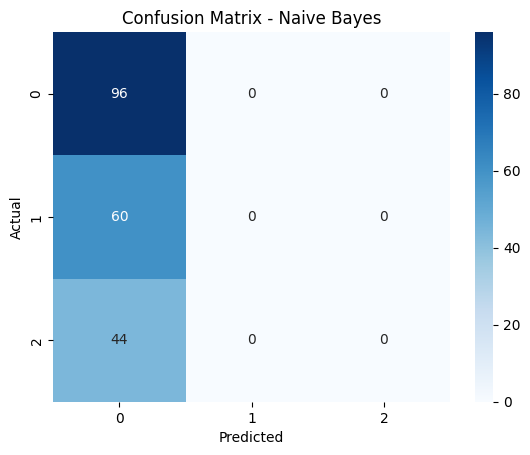


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        96
           1       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        44

    accuracy                           0.48       200
   macro avg       0.16      0.33      0.22       200
weighted avg       0.23      0.48      0.31       200



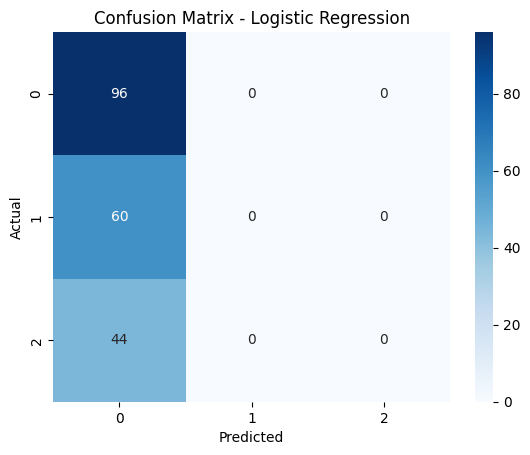


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        96
           1       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        44

    accuracy                           0.48       200
   macro avg       0.16      0.33      0.22       200
weighted avg       0.23      0.48      0.31       200



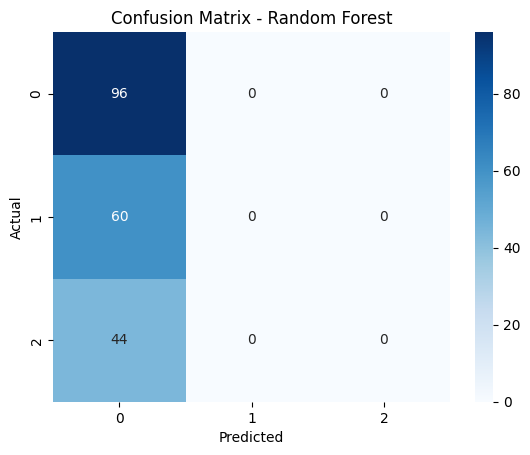

In [ ]:
print("\n5. MODEL TRAINING & EVALUATION")
print("-" * 40)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [ ]:
sample = ["I am receiving constant calls from debt collectors."]
sample_clean = clean_text(sample[0])
sample_vec = vectorizer.transform([sample_clean])

pred = models["Logistic Regression"].predict(sample_vec)
print(f"Predicted Category: {pred[0]}")


Predicted Category: 0
